# clustering of strains - tree or dist matrix based

* https://www.biorxiv.org/content/10.1101/2023.02.03.527052v1.full

In [519]:
import sys,os,random,time,string,itertools
import json
import subprocess
import math
from importlib import reload
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
import networkx as nx
from IPython.display import display, HTML
import toyplot,toytree

from btbabm import models,utils
from snipgenie import clustering,tools,plotting

In [ ]:
reload(models)
reload(utils)
model = models.FarmPathogenModel(F=20,C=400,S=8,seq_length=500)
model.run(500)
gdf, snpdist, meta = model.get_metadata(treefile='cluster_test/tree.newick')
utils.draw_tree('cluster_test/tree.newick')
snpdist.to_csv('cluster_test/snpdist.csv')
meta.to_csv('cluster_test/meta.csv',index=False)

In [859]:
#test data
snpdist = pd.read_csv('cluster_test/snpdist.csv',index_col=0)
meta = pd.read_csv('cluster_test/meta.csv')
treefile = 'cluster_test/tree.newick'
X=meta.set_index('id')[['species','strain']]
print (len(snpdist),len(meta))

70 70


In [908]:
#ireland data
snpdist = pd.read_csv('/storage/btbgenie/all_ireland_results/snpdist.csv',index_col=0)
meta = pd.read_csv('/storage/btbgenie/all_ireland_results/metadata.csv')
treefile = '/storage/btbgenie/all_ireland_results/tree.newick'
X=meta.set_index('sample')[['Species','SB','County']]
print (len(snpdist),len(X))

1256 1256


In [898]:
#mon data
snpdist = pd.read_csv('/storage/btbgenie/monaghan/monaghan_results/snpdist.csv',index_col=0)
meta = pd.read_csv('/storage/btbgenie/monaghan/metadata/master.csv')
treefile = '/storage/btbgenie/monaghan/monaghan_results/tree.newick'# '/storage/btbgenie/combined_results/tree.newick'
meta.iloc[0]
X=meta.set_index('sample')

In [917]:
def dm_cluster2(distance_matrix, t, prev_clusters=None):
    """
    Given a Pandas dataframe distance matrix and a distance threshold t, finds the clusters of the
    samples such that all members of a cluster are within t of each other.
    
    Parameters:
        distance_matrix (pandas.DataFrame): N x N distance matrix where N is the number of samples
        t (float): distance threshold
        previous_clusters (dataframe): previous cluster labels (optional)
        
    Returns:
        list: a list of cluster labels for each sample
        dataframe: a dataframe of the clusters that each sample is in
    """
    
    from sklearn.cluster import AgglomerativeClustering
    clustering = AgglomerativeClustering(distance_threshold=t, n_clusters=None, 
                                         linkage='complete', metric='precomputed').fit(distance_matrix)
    labels = clustering.labels_
    clusters = pd.DataFrame(labels,columns=['cluster'],index=distance_matrix.index)
    if prev_clusters is not None:
        labels,clusters = reassign_clusters(clusters, labels, prev_clusters)
    return labels, clusters

In [1039]:
reload(clustering)

T=50
scol='snp'+str(T)

def get_subset(snpdist,X,n=10):
    sub = list(snpdist.sample(n).index)
    S = snpdist.loc[sub,sub]
    X=X.loc[sub]
    return S,X
    
def get_tree(S):
  
    tree = toytree.tree(treefile)
    tips = list(snpdist.drop(S.index).index)
    subtree = tree.drop_tips(tips)
    subtree.write('sub.newick')
    return 

S2,X2 = get_subset(snpdist,X,n=50)
S1,X1 = get_subset(S2,X2,n=40)
labels,clusters1 = dm_cluster2(S1, T)
X1[scol]=labels
get_tree(S1)
#X1.style.applymap(lambda x: "background-color: %s" %clustering.snp200_cmap[x], subset=[scol])

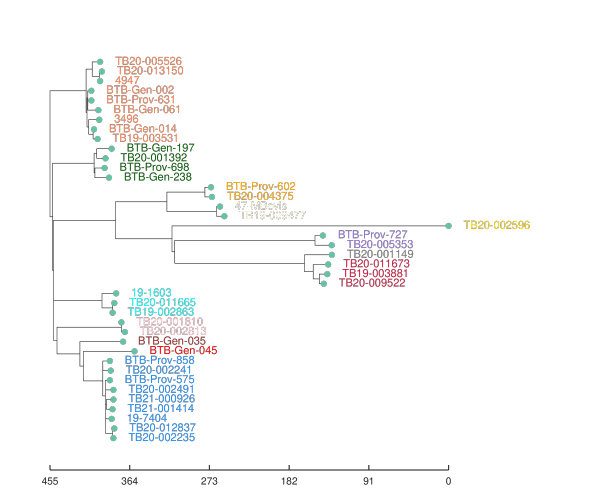

In [1040]:
utils.draw_tree('sub.newick',X1,scol,tip_labels=True,width=600,cmap=clustering.snp200_cmap)

In [1041]:
labels,clusters2 = dm_cluster2(S2, T,clusters1)
X2[scol]=labels
get_tree(S2)
utils.draw_tree('sub.newick',X2,scol,tip_labels=True,width=600,cmap=clustering.snp200_cmap)
cm=dict(zip(X2[scol],X2.color))
#X2.style.applymap(lambda x: "background-color: %s" %clustering.snp200_cmap[x], subset=[scol])

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="600.0px" height="500.0px" viewBox="0 0 600.0 500.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="te9c982945d174239904f35c6f7bf7cd5"> TB20-002235 TB20-012837 19-7404 TB21-001414 TB21-000926 TB20-002491 BTB-Prov-575 TB20-002241 BTB-Prov-858 BTB-Gen-045 BTB-Gen-001 TB20-001068 BTB-Gen-157 BTB-Gen-035 BTB-Prov-562 TB20-002813 TB20-001810 5572 19-1603 TB19-002863 TB20-011665 TB20-001479 TB20-011673 TB20-009522 TB19-003881 TB20-001149 TB20-005353 BTB-Prov-552 BTB-Prov-727 TB20-002596 TB19-009477 47-MBovis TB20-004375 BTB-Prov-602 BTB-Gen-238 BTB-Prov-698 TB20-001392 BTB-Gen-197 TB19-003531 BTB-Gen-014 19-3761 TB20-000462 3496 BTB-Gen-061 BTB-Prov-631 BTB-Gen-002 4947 TB20-013150 TB20-005526 TB20-001546 0 91 182 273 364 455

In [ ]:
cg = sns.clustermap(S, cmap='Blues', row_colors=X1.color,figsize=(6,6))
p=plotting.make_legend(cg.fig, cm, loc=(1.1, .6), title='cluster',fontsize=10)

In [ ]:
reload(utils)
reload(clustering)
labels,clusters = dm_cluster2(snpdist, T, prevclusters)

X[scol]=labels
#print (newclusters)
cm=clustering.snp200_cmap
utils.draw_tree(treefile,X,scol,tip_labels=False,height=700)#,cmap=cm)
cg=sns.clustermap(snpdist, cmap='Blues', row_colors=X.color,xticklabels=[],figsize=(8,8))
cm=dict(zip(X[scol],X.color))
p=plotting.make_legend(cg.fig, cm, loc=(1.1, .6), title='cluster',fontsize=10)
#X.style.applymap(lambda x: "background-color: %s" %clustering.snp200_cmap[x], subset=[scol])

In [905]:
def reassign_clusters(clusters, labels, prevclusters):
    """Re-assign cluster names to match previous ones."""

    new=[]
    df=clusters.merge(prevclusters,left_index=True,right_index=True)
    cnt = max(prevclusters.cluster)+1
    for c,g in clusters.groupby('cluster'):
        #print (c)       
        f = df.loc[df.index.isin(g.index)]
        #print (f)
        if len(f)>0:
            nc = f.iloc[0].cluster_y            
        else:
            nc = cnt
            cnt+=1
        g['cluster'] = nc
        #print(g)
        new.append(g)
        
    final = pd.concat(new)
    final = final.loc[clusters.index]
    #print('curr labels:',labels)
    newlabels=list(final.cluster)
    return newlabels, final

newlabels,newcl=reassign_clusters(clusters, labels2, prevclusters)

In [ ]:
X.groupby(['snp200','SB']).count().sort_values('Species')[-12:]
#X.to_csv('newclusts.csv')
w=X[X[scol].isin([1,12])].index
W=snpdist.loc[w,w]
#sns.heatmap(W)
X.loc[W.index]

## strain naming from clusters

In [1042]:
reload(clustering)
cl,members1 = clustering.get_cluster_levels(S1)
st1 = clustering.generate_strain_names(cl,S1)
#st1

In [1043]:
cl,members2 = clustering.get_cluster_levels(S2,members1)
st2 = clustering.generate_strain_names(cl,S2)
#st2

In [1044]:
st2.merge(st1,left_index=True,right_index=True,how='left')

,snp200_x,snp50_x,snp12_x,snp3_x,strain_name_x,code_x,snp200_y,snp50_y,snp12_y,snp3_y,strain_name_y,code_y
TB20-002813,0,6,6,0,ST-0-6-0-0001,3d59fdf5,0.0,6.0,6.0,0.0,ST-0-6-0-0001,3d59fdf5
TB20-001810,0,6,6,0,ST-0-6-0-0002,3d59fdf5,0.0,6.0,6.0,0.0,ST-0-6-0-0002,3d59fdf5
TB19-002863,0,8,1,1,ST-0-8-1-0001,298127f3,0.0,8.0,1.0,1.0,ST-0-8-1-0002,298127f3
TB20-011665,0,8,1,1,ST-0-8-1-0002,298127f3,0.0,8.0,1.0,1.0,ST-0-8-1-0001,298127f3
TB19-003531,0,1,2,2,ST-0-1-2-0001,873f388c,0.0,1.0,2.0,2.0,ST-0-1-2-0001,873f388c
BTB-Gen-238,0,0,3,3,ST-0-0-3-0001,d311e156,0.0,0.0,3.0,3.0,ST-0-0-3-0001,d311e156
TB20-001392,0,0,4,4,ST-0-0-4-0001,ceb3f55a,0.0,0.0,4.0,4.0,ST-0-0-4-0001,ceb3f55a
TB20-002235,0,2,11,5,ST-0-2-5-0001,8f9a34be,0.0,2.0,11.0,5.0,ST-0-2-5-0001,8f9a34be
47-MBovis,1,9,14,6,ST-1-9-6-0001,e205e42f,1.0,9.0,14.0,6.0,ST-1-9-6-0001,e205e42f
19-7404,0,2,7,7,ST-0-2-7-0001,f3a10227,0.0,2.0,7.0,7.0,ST-0-2-7-0001,f3a10227
